# Modeling <a id='Modeling'></a>

### 1 Table of Contents<a id='Contents'></a>
* [Modeling](#Modeling)
  * [1 Contents](#Contents)
  * [2 Introduction](#2_Introduction)
  * [3 Imports](#3_Imports)
  * [4 Datasets and Dataloaders](#4_Datasets_and_Dataloaders)
  * [5 SpatioTemporal Model](#5_SpatioTemporal_Model)
  * [6 Spatial Model with Weather Features](#6_Spatial_Model_with_Weather_Features)
  * [7 Best Model](#7_Best_Model)
  * [Conclusion](#Conclusion)

### 2 Introduction <a id='2_Introduction'></a>

In the last notebook, we created the tensor, split the data, and stored it in an h5py file. In this notebook, we'll be building our models.

### 3 Imports <a id='3_Imports'>

In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.attention import stgcn
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import grid
import torch.nn as nn
import torch.optim as optim
import gc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import h5py
import googlemaps
import os.path as osp
import math
import csv

### 4 Datasets and Dataloaders <a id='4_Datasets_and_Dataloaders'>

In [2]:
class H5GeometricTemporal(object):
    def __init__(self, path, set_name):
        self.set_name = set_name
        self.path = path
        super().__init__()
        
    def _get_edges(self):
        edge_index, pos = grid(height = 50, width = 30)
        self.edges = edge_index
    
    def _generate_task(self):
        self.data = h5py.File(self.path, 'r')
        self.set = self.data[self.set_name]
        self.features = []
        self.targets = []
        for idx in range(self.set.shape[0]):
            x = self.set[idx,:-1]
            x = np.array(x)
            x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2]))
            x = np.transpose(x)
            y = self.set[idx,-1]
            y = np.array(y)
            y = np.reshape(y, y.shape[0]*y.shape[1])
            y = np.expand_dims(y, axis = 1)
            y = np.append(y, y, 1)
            for idx1 in range(y.shape[0]):
                if (y[idx1,1] == 0):
                    y[idx1,1] = 1
                else:
                    y[idx1,1] = 0
            y[:, [1, 0]] = y[:, [0, 1]]
            self.features.append(x)
            self.targets.append(y)
            
    def get_dataset(self):
        self._get_edges()
        self._generate_task()
        dataset = StaticGraphTemporalSignal(self.edges, None, self.features, self.targets)
        return dataset

In [3]:
train_temporal_loader = H5GeometricTemporal('../Data/LA_windowed_split.hdf5', 'train_windowed')
train_temporal = train_temporal_loader.get_dataset()
test_temporal_loader = H5GeometricTemporal('../Data/LA_windowed_split.hdf5', 'test_windowed')
test_temporal = test_temporal_loader.get_dataset()

In [4]:
class H5Geometric(Dataset):
    def __init__(self, root, set_name, transform = None, pre_transform = None):
        self.set_name = set_name
        self.processed_file_names = []
        if (self.set_name == 'train'):
            for idx in range(78888):
                self.processed_file_names.append(f'data_train_{idx}.pt')
        else:
            for idx in range(26296):
                self.processed_file_names.append(f'data_test_{idx}.pt')
        super().__init__(root, transform, pre_transform)
        
    def raw_file_names(self):
        return 'LA_data_split_random.hdf5'

    def processed_file_names(self):
        return self.processed_file_names

    def process(self):
        self.data = h5py.File(self.raw_paths[0], 'r')
        self.set = self.data[self.set_name]
        edge_index, pos = grid(height = 50, width = 30, device = 'cuda:0')
        for idx in range(self.set.shape[0]):
            x = self.set[idx,:,:,1:]
            x = t.tensor(x).reshape(x.shape[0]*x.shape[1], x.shape[2])
            y = self.set[idx,:,:,0]
            y = t.tensor(y).reshape(y.shape[0]*y.shape[1])
            y = y[:,None]
            y = t.cat((y, y), dim = 1)
            for idx1 in range(y.shape[0]):
                if (y[idx1,1] == 0):
                    y[idx1,1] = 1
                else:
                    y[idx1,1] = 0
            y[:, [1, 0]] = y[:, [0, 1]]
            
            data = Data(x = x,
                        edge_index = edge_index,
                        y = y
                       )
            t.save(data, osp.join(self.processed_dir, f'data_{self.set_name}_{idx}.pt'))
        
    def len(self):
        return len(self.processed_file_names)
    
    def get(self, idx):
        data = t.load(osp.join(self.processed_dir, f'data_{self.set_name}_{idx}.pt'))
        return data

In [5]:
train_random = H5Geometric('../Data/', 'train')
train_random_loader = DataLoader(train_random, shuffle = True, batch_size = 8)
test_random = H5Geometric('../Data/', 'test')
test_random_loader = DataLoader(test_random, shuffle = False, batch_size = 8)

In [6]:
gc.collect()

40

In [7]:
def ACC(pred, actual):
    _, actual = t.max(actual, 1)
    _, pred = t.max(pred, 1)
    actual = np.array(actual.cpu())
    pred = np.array(pred.cpu())
    actual_inv = 1 - actual
    pred_inv = 1 - pred
    true_positives = np.logical_and(pred, actual).sum()
    false_positives = np.logical_and(pred, actual_inv).sum()
    false_negatives = np.logical_and(pred_inv, actual).sum()
    true_negatives = np.logical_and(pred_inv, actual_inv).sum()
    return true_positives, false_positives, false_negatives, true_negatives

### 5 SpatioTemporal Model <a id='5_SpatioTemporal_Model'>

In [8]:
class RecurrentGCN(nn.Module):
    def __init__(self, node_features, num_classes):
        super(RecurrentGCN, self).__init__()
        self.recurrent_1 = GConvGRU(node_features, 32, 5)
        self.recurrent_2 = GConvGRU(32, 16, 5)
        self.linear = nn.Linear(16, num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = self.recurrent_1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.recurrent_2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)

In [9]:
model = RecurrentGCN(node_features = 5, num_classes = 2)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = t.FloatTensor([1.0, 25.0]).cuda())

In [10]:
test_BCE_totals = []
test_prec_totals = []
test_rec_totals = []

model.train()
for time, snapshot in enumerate(train_temporal):
    x = snapshot.x.cuda()
    edge_index = snapshot.edge_index.cuda()
    edge_weight = snapshot.edge_weight
    y = snapshot.y.cuda()
    y_pred = model(x, edge_index, edge_weight)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (time%7000 == 0) and (time != 0):
        model.eval()
        with t.no_grad():
            test_BCEs = []
            test_true_positives = 0
            test_false_positives = 0
            test_false_negatives = 0
            test_true_negatives = 0
            for snapshot in test_temporal:
                x = snapshot.x.cuda() 
                edge_index = snapshot.edge_index.cuda()
                edge_weight = snapshot.edge_weight
                y = snapshot.y.cuda()
                y_pred = model(x, edge_index, edge_weight)
                test_BCE = loss_fn(y_pred, y)
                test_BCEs.append(test_BCE.cpu())
                true_positives, false_positives, false_negatives, true_negatives = ACC(y_pred, y)
                test_true_positives += true_positives
                test_false_positives += false_positives
                test_false_negatives += false_negatives
                test_true_negatives += true_negatives
            test_BCE_avg = np.array(test_BCEs).mean()
            test_class0_recall = test_true_negatives / (test_true_negatives + test_false_positives)
            test_class0_precision = test_true_negatives / (test_true_negatives + test_false_negatives)
            test_class0_f1 = 2 * (test_class0_precision * test_class0_recall) / (test_class0_precision + test_class0_recall)
            test_class1_recall = test_true_positives / (test_true_positives + test_false_negatives)
            test_class1_precision = test_true_positives / (test_true_positives + test_false_positives)
            test_class1_f1 = 2 * (test_class1_precision * test_class1_recall) / (test_class1_precision + test_class1_recall)
            test_accuracy = (test_true_positives + test_true_negatives) / (test_true_positives + test_false_positives
                                                                            + test_false_negatives + test_true_negatives)
            test_BCE_totals.append(test_BCE_avg)
            test_prec_totals.append(test_class1_precision)
            test_rec_totals.append(test_class1_recall)
        print("\t\tprecision\trecall\t\tf1-score")
        print()
        print("Class 0\t\t%.4f\t\t%.4f\t\t%.4f" % (test_class0_precision, test_class0_recall, test_class0_f1))
        print("Class 1\t\t%.4f\t\t%.4f\t\t%.4f" % (test_class1_precision, test_class1_recall, test_class1_f1))
        print("Accuracy\t\t\t\t\t%.4f" % (test_accuracy))
        print()
        print("Batch %d: test BCE %.4f" % (math.floor(time/7000), test_BCE_avg))
        print("---------------------------------------------------------")
        gc.collect()
        model.train()

		precision	recall		f1-score

Class 0		0.9992		0.9777		0.9883
Class 1		0.1250		0.8043		0.2164
Accuracy					0.9770

Batch 1: test BCE 0.4228
---------------------------------------------------------
		precision	recall		f1-score

Class 0		0.9990		0.9820		0.9905
Class 1		0.1437		0.7596		0.2417
Accuracy					0.9812

Batch 2: test BCE 0.4205
---------------------------------------------------------
		precision	recall		f1-score

Class 0		0.9990		0.9828		0.9908
Class 1		0.1470		0.7487		0.2457
Accuracy					0.9818

Batch 3: test BCE 0.4197
---------------------------------------------------------
		precision	recall		f1-score

Class 0		0.9990		0.9829		0.9909
Class 1		0.1480		0.7483		0.2471
Accuracy					0.9820

Batch 4: test BCE 0.4194
---------------------------------------------------------
		precision	recall		f1-score

Class 0		0.9990		0.9833		0.9911
Class 1		0.1501		0.7449		0.2498
Accuracy					0.9823

Batch 5: test BCE 0.4193
---------------------------------------------------------
		precisio

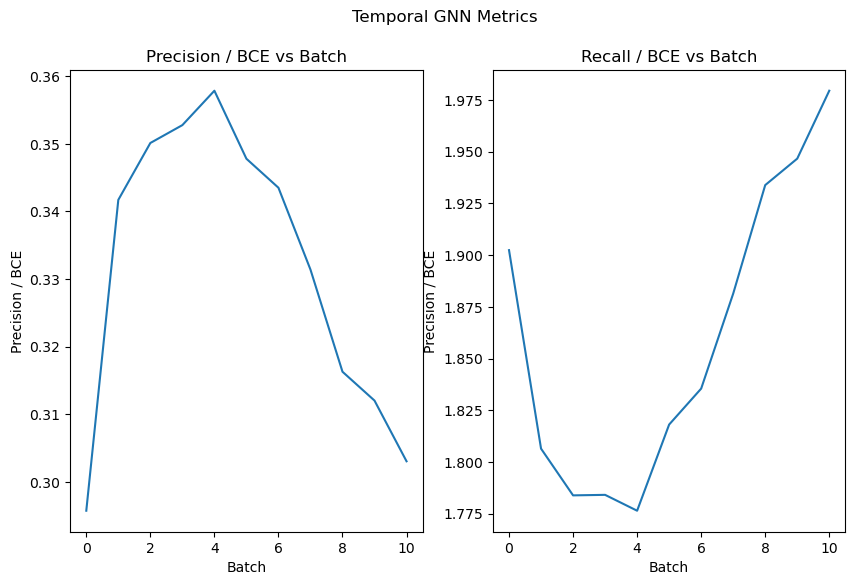

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(np.arange(0, 11), (np.array(test_prec_totals) / np.array(test_BCE_totals)))
ax[0].set_xlabel('Batch')
ax[0].set_ylabel('Precision / BCE')
ax[0].set_title('Precision / BCE vs Batch')
ax[1].plot(np.arange(0, 11), (np.array(test_rec_totals) / np.array(test_BCE_totals)))
ax[1].set_xlabel('Batch')
ax[1].set_ylabel('Precision / BCE')
ax[1].set_title('Recall / BCE vs Batch')
fig.suptitle("Temporal GNN Metrics")

plt.show()

In [12]:
gc.collect()

10

### 6 Spatial Model with Weather Features <a id='6_Spatial_Model_with_Weather_Features'>

In [13]:
class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(11, 16)
        self.conv2 = GCNConv(16, 11)
        self.linear = nn.Linear(11, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)

In [31]:
model2 = GCN()
model2.cuda()
optimizer = optim.Adam(model2.parameters(), lr = 0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = t.FloatTensor([1.0, 25.0]).cuda())

In [32]:
test_BCE_totals = []
test_prec_totals = []
test_rec_totals = []

model2.train()
for batch, data in enumerate(train_random_loader):
    x = data.x.type(t.cuda.FloatTensor)
    edge_index = data.edge_index.type(t.cuda.LongTensor)
    y = data.y.type(t.cuda.FloatTensor)
    y_pred = model2(x, edge_index)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (batch%875 == 0) and (batch != 0):
        model2.eval()
        with t.no_grad():
            test_BCEs = []
            test_true_positives = 0
            test_false_positives = 0
            test_false_negatives = 0
            test_true_negatives = 0
            for data in test_random_loader:
                x = data.x.type(t.cuda.FloatTensor)
                edge_index = data.edge_index.type(t.cuda.LongTensor)
                y = data.y.type(t.cuda.FloatTensor)
                y_pred = model2(x, edge_index)
                test_BCE = loss_fn(y_pred, y)
                test_BCEs.append(test_BCE.cpu())
                true_positives, false_positives, false_negatives, true_negatives = ACC(y_pred, y)
                test_true_positives += true_positives
                test_false_positives += false_positives
                test_false_negatives += false_negatives
                test_true_negatives += true_negatives
            test_BCE_avg = np.array(test_BCEs).mean()
            test_class0_recall = test_true_negatives / (test_true_negatives + test_false_positives)
            test_class0_precision = test_true_negatives / (test_true_negatives + test_false_negatives)
            test_class0_f1 = 2 * (test_class0_precision * test_class0_recall) / (test_class0_precision + test_class0_recall)
            test_class1_recall = test_true_positives / (test_true_positives + test_false_negatives)
            test_class1_precision = test_true_positives / (test_true_positives + test_false_positives)
            test_class1_f1 = 2 * (test_class1_precision * test_class1_recall) / (test_class1_precision + test_class1_recall)
            test_accuracy = (test_true_positives + test_true_negatives) / (test_true_positives + test_false_positives
                                                                            + test_false_negatives + test_true_negatives)
            test_BCE_totals.append(test_BCE_avg)
            test_prec_totals.append(test_class1_precision)
            test_rec_totals.append(test_class1_recall)
        print("TESTING DATA")
        print("\t\tprecision\trecall\t\tf1-score")
        print()
        print("Class 0\t\t%.4f\t\t%.4f\t\t%.4f" % (test_class0_precision, test_class0_recall, test_class0_f1))
        print("Class 1\t\t%.4f\t\t%.4f\t\t%.4f" % (test_class1_precision, test_class1_recall, test_class1_f1))
        print("Accuracy\t\t\t\t\t%.4f" % (test_accuracy))
        print()
        print("Batch %d: test BCE %.4f" % (math.floor(batch/875), test_BCE_avg))
        print("---------------------------------------------------------")
        gc.collect()
        model2.train()

TESTING DATA
		precision	recall		f1-score

Class 0		0.9992		0.9596		0.9790
Class 1		0.0853		0.8224		0.1545
Accuracy					0.9590

Batch 1: test BCE 8.7204
---------------------------------------------------------
TESTING DATA
		precision	recall		f1-score

Class 0		0.9985		0.9718		0.9850
Class 1		0.0996		0.6806		0.1738
Accuracy					0.9705

Batch 2: test BCE 2.3289
---------------------------------------------------------
TESTING DATA
		precision	recall		f1-score

Class 0		0.9958		0.9962		0.9960
Class 1		0.0841		0.0768		0.0803
Accuracy					0.9920

Batch 3: test BCE 0.7792
---------------------------------------------------------
TESTING DATA
		precision	recall		f1-score

Class 0		0.9955		0.9995		0.9975
Class 1		0.0681		0.0078		0.0140
Accuracy					0.9950

Batch 4: test BCE 0.6813
---------------------------------------------------------
TESTING DATA
		precision	recall		f1-score

Class 0		0.9955		0.9997		0.9976
Class 1		0.0696		0.0047		0.0089
Accuracy					0.9952

Batch 5: test BCE 0.6294
---

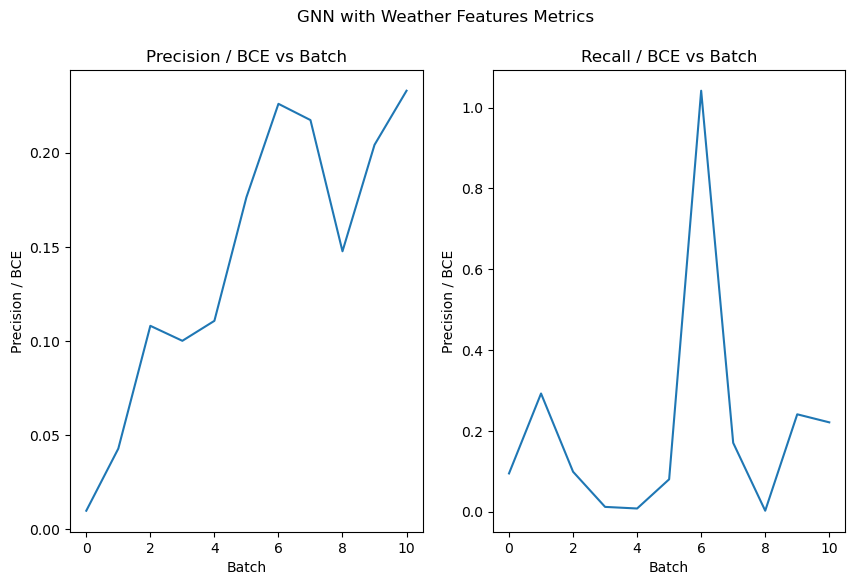

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(np.arange(0, 11), (np.array(test_prec_totals) / np.array(test_BCE_totals)))
ax[0].set_xlabel('Batch')
ax[0].set_ylabel('Precision / BCE')
ax[0].set_title('Precision / BCE vs Batch')
ax[1].plot(np.arange(0, 11), (np.array(test_rec_totals) / np.array(test_BCE_totals)))
ax[1].set_xlabel('Batch')
ax[1].set_ylabel('Precision / BCE')
ax[1].set_title('Recall / BCE vs Batch')
fig.suptitle("GNN with Weather Features Metrics")

plt.show()

### 7 Best Model <a id='7_Best_Model'>

The best model was the Temporal GNN. Although, it's not that good. Let's look at the confusion matrix for the output of that model.

In [34]:
gc.collect()

6091

In [35]:
model2.eval()
with t.no_grad():
    test_true_positives = 0
    test_false_positives = 0
    test_false_negatives = 0
    test_true_negatives = 0
    for data in test_random_loader:
        x = data.x.type(t.cuda.FloatTensor)
        edge_index = data.edge_index.type(t.cuda.LongTensor)
        y = data.y.type(t.cuda.FloatTensor)
        y_pred = model2(x, edge_index)
        true_positives, false_positives, false_negatives, true_negatives = ACC(y_pred, y)
        test_true_positives += true_positives
        test_false_positives += false_positives
        test_false_negatives += false_negatives
        test_true_negatives += true_negatives       

In [37]:
cf_matrix = np.array([[test_true_negatives, test_false_positives], [test_false_negatives, test_true_positives]])

<AxesSubplot:>

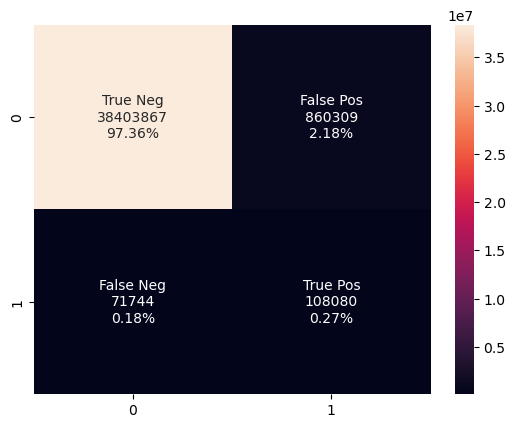

In [43]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='')

### Conclusion <a id='Conclusion'>

Neither model tested here works exceptionally well. This is not too unexpected, as traffic accidents are dependent on much more than weather, traffic counts, or other nearby or previous accidents. There are many more factors that were outside the scope of my data. Both models are able to correctly predict the presence of accidents more often than a zero rate or weighted rate classifier. However, the large rate of false positives and false negatives certainly makes the model too inaccurate to be used in a real life setting.